# Calculating and saving all metrics

_Alex I. Malz (GCCL@RUB) & Emille Ishida (LPC@Clermont-Ferrand)_

In [1]:
import pandas as pd
import matplotlib.pylab as plt
# import seaborn as sns
import numpy as np
import os

import gzip
import scipy.stats as sps
import sys

## data preprocessing

class naming scheme

In [2]:
SNANA_names = {11: 'Ia', 3:'Ibc', 13: 'Ibc', 2:'II', 12:'II', 14:'II',
               41: '91bg', 43:'Iax', 51:'KN', 60:'SLSN', 61:'PISN', 62:'ILOT',
               63:'CART', 64:'TDE', 70:'AGN', 80:'RRL', 81:'M-dwarf', 83:'EB',
               84:'Mira', 90:'MicroLB', 91:'MicroL', 93:'MicroL'}

how to name saved files

In [3]:
# # these are for what to name saved files
# alex = False
# redo = True

which test cas to run (because one big loop would be awful, although this should really be a script that runs them in parallel)

In [4]:
k_version = '9'
field = 'WFD'
nobj = '3000'
    
dirname = '/media/RESSPECT/data/PLAsTiCC/for_metrics/final_data3/'+field+'/results/v'+k_version+'/'+nobj+'/'
sampdir = dirname + 'samples/'
cases = os.listdir(sampdir)

if '.ipynb_checkpoints' in cases:
    cases.remove('.ipynb_checkpoints')



# cases.remove('random1500.csv')
# cases.remove('random6000.csv')
# cases.remove('fiducial1500.csv')
# cases.remove('fiducial6000.csv')
# cases.remove('perfect6000.csv')
# cases.remove('perfect1500.csv')

manually remove cases that won't be in the same big plot

## how to calculate classification metrics

In [5]:
import proclam
from proclam.metrics.util import *
from proclam.metrics.util import RateMatrix

class for binary classification metrics

TODO: add in checks for between 0 and 1

TODO: put this in proclam

In [6]:
class det_mets(RateMatrix):
    "binary classification metrics"
    def __init__(self, **rates):
        """
        Call like `thing = det_mets(**rates._asdict())`
        """
#         self.rates = rates#.asdict()
        self._get_tots()
        self._from_rates()
        self._sn_mets()
        self._translate()
    def _get_tots(self):
        self.CP = self.TP + self.FN
        self.CN = self.TN + self.FP
        self.T = self.TP + self.TN
        self.F = self.FP + self.FN
        self.P = self.TP + self.FP
        self.N = self.TN + self.FN
    def _from_rates(self):
        self.PPV = self.TP / (self.TP + self.FP)
        self.NPV = self.TN / (self.TN + self.FN)
        self.PT = (np.sqrt(self.TPR * (1. - self.TNR)) + self.TNR - 1.) / (self.TPR + self.TNR - 1.)
        self.TS = self.TP / (self.TP + self.FN + self.FP)
        self._derived()
    def _derived(self):
        self.ACC = (self.TP + self.TN) / (self.CP + self.CN)
        self.BA = (self.TPR + self.TNR) / 2.,
        self.F1S = 2. * self.PPV * self.TPR / (self.PPV + self.TPR)
        self.MCC = (self.TP * self.TN - self.FP * self.FN) / (np.sqrt(self.P * self.CP * self.CN * self.N))
        self.FM = np.sqrt(self.PPV * self.TPR)
        self.BM = self.TPR + self.TNR - 1.
        self.MK = self.PPV + self.NPV - 1.
    def _translate(self):
        self.positive = self.CP
        self.negative = self.CN
        self.sensitivity = self.TPR
        self.recall = self.TPR
        self.specificity = self.TNR
        self.selectivity = self.TNR
        self.precision = self.PPV
        self.FDR = 1. - self.PPV
        self.FOR = 1. - self.NPV
        self.CSI = self.TS
        self.accuracy = self.ACC
        self.f1_score = self.F1S
        self.informedness = self.BM
        self.deltaP = self.MK
    def _sn_mets(self):
        self.get_efficiency()
        self.get_purity()
    def get_efficiency(self):
        self.efficiency = self.TP / self.CP
        return self.efficiency
    def get_purity(self):
        self.purity = self.TP / self.P
        return self.purity
    def get_fom(self, penalty):
        self.pseudo_purity = self.TP / (self.TP + penalty * self.FP)
        fom = self.pseudo_purity * self.efficiency
        return fom
    

make the proclam ratematrix from information we know about each test case

In [7]:
def nums_to_rate(tot, P, T, FP):
    N = tot - P
    TN = N - FP
    F = tot - T
    FN = F - TN
    TP = P - FN
    assert(FP + FN + TP + TN == tot)
    
    TPR = TP / P
    FPR = FP / N
    FNR = FN / P
    TNR = TN / N
    
#     cm = np.array([[totIa - cont, totall - ], [, cont]])
    rate = proclam.util.RateMatrix(TPR=TPR, FPR=FPR, FNR=FNR, TNR=TNR, TP=TP, FN=FN, TN=TN, FP=FP)
    return rate

define the true number of objects available in each sample before and after SALT2 fit as filter

In [8]:
total = {}
total['DDF'] = {}                     # total number of objects in the sample
# total['DDF']['before_salt2'] = 4335
total['DDF']['after_salt2'] = int(8613 / 10228 * int(nobj)) #3456
total['WFD'] = {}
# total['WFD']['before_salt2'] = 5588
total['WFD']['after_salt2'] = int(999789 / 1094829 * int(nobj)) #3306

calculate the metrics from the available numbers of objects

In [9]:
def classification_metrics(cont, totIa=3000, before_salt2=False, field=field):
    """Classification metrics for a sample of 3k SNIa.
    
    Parameters
    ----------
    cont: int < totIa
        number of contaminant objects
    totIa: int (optional)
        Number of Ia in the sample. Default is 3000.
    before_salt2: bool (optional)
        If True use total sample number before SALT2 fit.
        Default is False.
    field: str (optional)
        Cadence: 'DDF' or 'WFD'. Default is DDF.
        
    Returns
    -------
    accuracy: float
    efficiency: float
    purity: float
    figure of merit (W=1): float
    figure of merit (W=3): float
    """
    
    if totIa != 3000:
        raise ValueError('Numbers are hard coded for 3000 SNIa.')
#         return(np.nan, np.nan, np.nan, np.nan, np.nan)
    
    if before_salt2:
        totall = total[field]['before_salt2']
    else:
        totall = total[field]['after_salt2']
    
    rate = nums_to_rate(tot=totall, P=totIa, T=totIa, FP=cont)._asdict()
    class_mets = det_mets(**rate)
    
    f3 = class_mets.get_fom(3.)

    return class_mets.accuracy, class_mets.get_efficiency(), class_mets.get_purity(), class_mets.f1_score, f3#class_mets.get_fom(3.)

demonstrate metrics on grid

In [10]:
res = 50
nsamp = 3000
totpop = 10000
plot_acc, plot_pur, plot_eff, plot_fom = np.empty(res), np.empty(res), np.empty(res), np.empty(res)

for i, c in enumerate(np.linspace(0., 1., res+2)[1:-1]):
    cont = c * nsamp
    rate = rate = nums_to_rate(tot=totpop, P=nsamp, T=nsamp, FP=cont)._asdict()
    class_mets = det_mets(**rate)
    plot_acc[i] = class_mets.accuracy
    plot_pur[i] = class_mets.get_efficiency()
    plot_eff[i] = class_mets.get_purity()
    plot_fom[i] = class_mets.get_fom(3.)

In [ ]:
# fig, ax = plt.subplots(3,3)
each_dim = {'accuracy': plot_acc, 'purity': plot_pur, 'efficiency': plot_eff, 'fom3': plot_fom}
pairs = [['purity', 'accuracy'], ['purity', 'efficiency'], ['accuracy', 'efficiency'],
         ['purity', 'fom3'], ['accuracy', 'fom3'], ['efficiency', 'fom3']]
ax = {}
map1 = {}
map1[0] = 0
map1[3] = 1
map1[4] = 2
map1[6] = 3
map1[7] = 4
map1[8] = 5
for i in [0,3,4,6,7,8]:
    k = map1[i]
    x, y = pairs[k][0], pairs[k][1]
    ax[i] = plt.subplot(3,3, i + 1)
    ax[i].plot(each_dim[x], each_dim[y])
#     ax[i].set_xlabel(x)
#     ax[i].set_ylabel(y)
    if i in [6,7,8]:
        plt.xlabel(pairs[k][0])
#         ax[i].xaxis.set_major_locator(loc)
        if i == 7:
            #plt.xticks(np.arange(0.4, 1.0, 0.1))
            plt.xticks([0.5, 0.7, 0.9])
    else:
        plt.xticks([])
            
    if i in [0,3,6]:
        plt.ylabel(pairs[k][1])
#         ax[i].yaxis.set_major_locator(loc)
#         if i == 3:
#             plt.yticks(np.arange(0.6, 1.05, 0.1))
    else:
        plt.yticks([])
        
    
plt.subplots_adjust(hspace=0., wspace=0.)
plt.savefig('plots/simple_metrics_corner.png', bbox_inches='tight')
#plt.show()

## how to calculate KLD

KLD is prone to numerical divergence when coverage between distributions is poor, so protect against overflow/underflow

In [12]:
eps = 2. * sys.float_info.min

def safe_log(arr, threshold=eps):
    """
    Takes the natural logarithm of an array that might contain zeros.

    Parameters
    ----------
    arr: ndarray, float
        array of values to be logged
    threshold: float, optional
        small, positive value to replace zeros and negative numbers

    Returns
    -------
    logged: ndarray
        logged values, with small value replacing un-loggable values
    """
    arr = np.asarray(arr)
    arr[arr < threshold] = threshold
    logged = np.log(arr)
    return logged

how to make a grid and fit ~~multidimensional~~ KDE to posterior samples (of $w$)

In [13]:
def make_grid(x, y, x_ngrid=100, y_ngrid=100):
    x_min = x.min()#-1.2
    x_max = x.max()#-0.8
    y_min = y.min()#0.2
    y_max = y.max()#0.4

    x_grid, y_grid = np.mgrid[x_min:x_max:x_ngrid*1.j, y_min:y_max:y_ngrid*1.j]
    x_vec, y_vec = x_grid[:, 0], y_grid[0, :]
    dx = (x_max - x_min) / (x_ngrid - 1)
    dy = (y_max - y_min) / (y_ngrid - 1)

    return(((x_min, y_min), (x_max, y_max)), (x_grid, y_grid), (x_vec, y_vec), (dx, dy))

def make_kde(Xgrid, Ygrid, Xsamps, Ysamps, to_log=False, save=None, one_d=True):
    if not one_d:
        positions = np.vstack([Xgrid.ravel(), Ygrid.ravel()])
        values = np.vstack([Xsamps, Ysamps])
        kernel = sps.gaussian_kde(values, bw_method='scott')
        Z = np.reshape(kernel(positions).T, Xgrid.shape)
    else:
        positions = Xgrid.T[0]
        values = Xsamps
        kernel = sps.gaussian_kde(values, bw_method='scott')
        Z = kernel(positions)
    
    if to_log:
        return safe_log(Z)
    else:
        return Z
#     if save is not None:
# TODO: normalize up here before log!

use chippr implementation of KLD

In [14]:
# stolen from chippr
def calculate_kld(lpe, lqe, dx, from_log=False, vb=True):
    """
    Calculates the Kullback-Leibler Divergence between two N-dimensional PDFs 
    evaluated on a shared, regular grid (sorry, too lazy to deal with irregular grid)

    Parameters
    ----------
    lpe: numpy.ndarray, float
        log-probability distribution evaluated on a grid whose distance from `q`
        will be calculated.
    lqe: numpy.ndarray, float
        log-probability distribution evaluated on a grid whose distance to `p` will
        be calculated.
    dx: numpy.ndarray, float
        separation of grid values in each dimension
    from_log: boolean, optional
        if False, lpe, lqe are probability distributions, not log-probability distributions
    vb: boolean, optional
        report on progress to stdout?

    Returns
    -------
    Dpq: float
        the value of the Kullback-Leibler Divergence from `q` to `p`
    """
    # Normalize the evaluations, so that the integrals can be done
    gridnorm = np.ones_like(lpe) * np.prod(dx)
    if from_log:
        pe = np.exp(lpe)
        qe = np.exp(lqe)
#     print(np.prod(dx))
#     print(gridnorm)
    else:
        pe = lpe
        qe = lqe
    pi = np.sum(pe * gridnorm)
    qi = np.sum(qe * gridnorm)
    # (very approximately!) by simple summation:
    pn = pe / pi
    qn = qe / qi
    # Compute the log of the normalized PDFs
    logp = safe_log(pn)
    logq = safe_log(qn)
    # Calculate the KLD from q to p
    Dpq = np.sum(pn * (logp - logq))
#     if np.isnan(Dpq):
#         return((lpe, lqe, dx))
    return Dpq

## Prep for the metrics calculations

set up for saving the metrics

In [15]:
names = []

pop_Ia_all = []
pop_nIa_all = []
perc_Ia_all = []
perc_nIa_all = []

wfit_w_all = []
wfit_wsig_all = []
wfit_om_all = []
wfit_omsig_all = []
wfit_w_all_lowz = []
wfit_wsig_all_lowz = []
wfit_om_all_lowz = []
wfit_omsig_all_lowz = []

stan_w_all = []
stan_wsig_all = []
stan_om_all = []
stan_omsig_all = []

stan_w_all_lowz = []
stan_wsig_all_lowz = []
stan_om_all_lowz = []
stan_omsig_all_lowz = []

other_index = []
other_name = []

wdist_median = []

eff = []
pur = []
acc = []
f1 = []
f3 = []

read Wasserstein distances

In [16]:
# if field == 'DDF':
#     fname = dirname + 'Wasserstein/wassersteinDistances_ddf'+k+'.dat'
# elif field == 'WFD':
#     fname = dirname + 'Wasserstein/wassersteinDistances_WFD'+k+'.dat'

# wdist = pd.read_csv(fname, index_col=1)
# wdist['FileB'][wdist['FileB'] == 'chains_perfect3000_lowz_withbias.csv.gz']

In [17]:
# # print(wdist)
# # name_flagA = np.array(['perfect3000' in name for name in wdist['FileA'].values])
# name_flagB = np.array(['perfect3000' in name for name in wdist['FileB'].values])
# # name_flag = np.logical_or(name_flagA, name_flagB)

# wdist = wdist[name_flagB]
# # if field == 'DDF':
# #     wdist_ddf = wdist[name_flag]
# # elif field == 'WFD':
# #     wdist_wfd = wdist[name_flag]

prep KDE for reference (closest to truth) distribution

In [18]:
path_pre = dirname#[:46]
path_post = 'posteriors/csv/'
refname = 'chains_perfect' + nobj + '_lowz_withbias.csv.gz'

# fieldstr = {'DDF': 'ddf', 'WFD': 'wfd'}

fullpath = path_pre + path_post
alloutputs = pd.DataFrame(columns=['path', 'KLD'])
    # make reference sample
with gzip.open(fullpath+refname) as reffn:
    flatref = pd.read_csv(reffn)
[w_ref, Omm_ref] = [flatref['w'], flatref['om']]
ref_extrema, ref_grids, ref_vecs, ref_ds = make_grid(w_ref, Omm_ref)
(w_vec, Omm_vec) = ref_vecs
(dw, dOmm) = ref_ds
((xmin, ymin), (xmax, ymax)) = ref_extrema
(w_grid, Omm_grid) = ref_grids
d_ref = {'w': dw, 'Omm': dOmm}
grid_ref = {'w': w_grid, 'Omm': Omm_grid}
kde_ref = make_kde(w_grid, Omm_grid, w_ref, Omm_ref, one_d=True, to_log=True)

diagnostic plots for the posterior samples

In [19]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# stolen from chippr
def fancyplot(xdata, ydata, xgrid, ygrid, xlab='', ylab='', title=''):
    # 2d KDE
    f, scatplot = plt.subplots(figsize=(7.5, 7.5))
    f.subplots_adjust(hspace=0)
    scatplot.hist2d(xdata, ydata, bins=[xgrid, ygrid], alpha=0.5, density=True, cmap=plt.cm.Blues)
    
    scatplot.set_xlabel(xlab, fontsize=20)
    scatplot.set_ylabel(ylab, fontsize=20)
    divider = make_axes_locatable(scatplot)
    histx = divider.append_axes('top', 1.2, pad=0., sharex=scatplot)
    histy = divider.append_axes('right', 1.2, pad=0., sharey=scatplot)
    histx.xaxis.set_tick_params(labelbottom=False)
    histy.yaxis.set_tick_params(labelleft=False)
    histx.hist(xdata, bins=xgrid, alpha=0.75, density=True)
    histy.hist(ydata, bins=ygrid, alpha=0.75, density=True, orientation='horizontal')
    histx.set_yticks([])
    histy.set_xticks([])
    scatplot.set_title(title, fontsize=24)
    f.show()

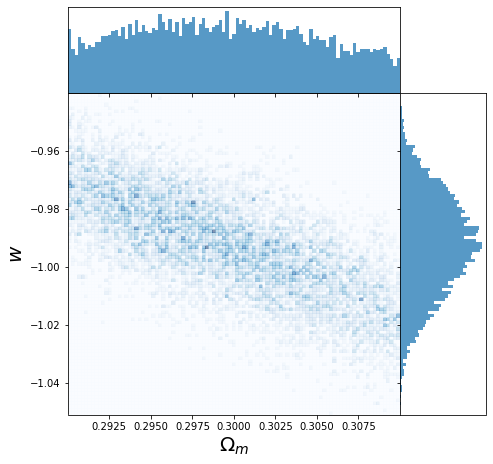

In [20]:
fancyplot(Omm_ref, w_ref, Omm_vec, w_vec, xlab=r'$\Omega_{m}$', ylab=r'$w$')

## read in cosmology outputs and calculate classification metrics

In [21]:
for case in cases:        
    names.append(case[:-4])
    
    pop = {}
    perc = {}

    samples_dir = case[:-4] + '/'
    
    data = pd.read_csv(dirname + 'samples/' + case, header=0, delimiter=' ')
    stats = np.unique(data['SIM_TYPE_INDEX'].values, return_counts=True)
    
    fname_cosmo_lowz = dirname+'cospar/test_salt2mu_lowz_withbias_'+case[:-4]+'.M0DIF.cospar'
    cosmofit_lowz = pd.read_csv(fname_cosmo_lowz, delim_whitespace=True,
                          comment='#', names=['w', 'wsig_marg',  'OM',  'OM_sig',  'chi2',  
                                              'Ndof',  'sigint', 'wran',  'OMran',  'label'])
    wfit_w_all_lowz.append(cosmofit_lowz['w'].values[0])
    wfit_wsig_all_lowz.append(cosmofit_lowz['wsig_marg'].values[0])
    wfit_om_all_lowz.append(cosmofit_lowz['OM'].values[0])
    wfit_omsig_all_lowz.append(cosmofit_lowz['OM_sig'].values[0])

    fname_stan = dirname+'stan_summary/stan_summary_'+case[:-4]+'_lowz_withbias.dat'
    op2 = open(fname_stan, 'r')
    lin2 = op2.readlines()
    op2.close()
    
    for j in range(len(lin2)):
        if lin2[j][:2] == 'om':
            om = lin2[j].split()[1]
            omsig = lin2[j].split()[3]
            stan_om_all_lowz.append(om)
            stan_omsig_all_lowz.append(omsig)
        elif lin2[j][0] == 'w':
            w = lin2[j].split()[1]
            wsig = lin2[j].split()[3]
            stan_w_all_lowz.append(w)
            stan_wsig_all_lowz.append(wsig)
            
    # classification metrics
    Ia_code = 11
    flag_Ia = np.array(stats[0]) == Ia_code
    
    pop[Ia_code] = stats[1][flag_Ia][0]
    perc[Ia_code] = round(100 * stats[1][flag_Ia][0]/data.shape[0])
    
    if  len(stats[0]) == 2:
        other_code = [item for item in stats[0] if item != Ia_code][0]
        pop[other_code] = stats[1][~flag_Ia][0]
        perc[other_code] = 100 * stats[1][~flag_Ia][0]/data.shape[0]
            
        pop_nIa_all.append(pop[other_code])
        perc_nIa_all.append(perc[other_code])
        other_index.append(other_code)
        other_name.append(SNANA_names[other_code])
        
    elif len(stats[0]) > 2:
        other_code = [item for item in stats[0] if item != Ia_code]
        for item in range(flag_Ia.shape[0]):
            if not flag_Ia[item]:
                pop[stats[0][item]] = stats[1][item]
                perc[stats[0][item]] = round(100 * stats[1][item]/data.shape[0])
                
        pop_nIa_all.append([pop[item] for item in other_code])
        perc_nIa_all.append([perc[item] for item in other_code])
        other_index.append(other_code)
        other_name.append([SNANA_names[i] for i in other_code])
        
    elif len(stats[0]) == 1:
        other_code = '--'
        pop_nIa_all.append(None)
        perc_nIa_all.append(None)
        other_index.append(None)
        other_name.append(None)

    pop_Ia_all.append(pop[Ia_code])
    perc_Ia_all.append(perc[Ia_code])
    
    tot = int(nobj)
    
    cont = tot - pop[Ia_code]
    
#     if field == 'DDF':
#         for i in range(wdist_ddf.shape[0]):
#             if case[:-4] in wdist_ddf['FileA'].values[i] or \
#                 case[:-4] in wdist_ddf['FileB'].values[i]:
#                 wdist_median.append(wdist_ddf['WassersteinDistanceMedian'].values[i])
#                 break
#     elif field == 'WFD':
#         if k in [1, '', 2, 3,4,5]:
#             for i in range(wdist_wfd.shape[0]):
#                 if case[:-4] in wdist_wfd['FileA'].values[i] or \
#                     case[:-4] in wdist_wfd['FileB'].values[i]:
#                     wdist_median.append(wdist_wfd['WassersteinDistanceMedian'].values[i])
#                     break
#         else:
#             wdist_median.append(-99)
#     for i in range(wdist.shape[0]):     
#     if 'chains_'+case[:-4]+'_lowz_withbias.csv.gz' in wdist.index:
#         wdist_median.append(wdist.loc['chains_'+case[:-4]+'_lowz_withbias.csv.gz']['WassersteinDistanceMedian'])
#     else:
#         print((case, 'b0rk!'))
#         wdist_median.append(-99)
    
    if tot == 3000:
        metrics = classification_metrics(cont)
    else: 
        print((cont, case))
        metrics = [np.nan, np.nan, np.nan, np.nan, np.nan]
    if not metrics:
        print((cont, case))
    acc.append(metrics[0])
    eff.append(metrics[1])
    pur.append(metrics[2])
    f1.append(metrics[3])
    f3.append(metrics[4])

data_all = {}

res = np.array(other_name)
for i, contaminant in enumerate(res):
    if type(contaminant) == list:
        if len(contaminant) <= 3:
            res[i] = contaminant[0]
        else:
            res[i] = 'mix'
    elif contaminant is None:
        res[i] = 'n/a'
data_all['other_short'] = res
        
data_all['case'] = names
data_all['nIa'] = pop_Ia_all
data_all['perc_Ia'] = perc_Ia_all
data_all['accuracy'] = acc
data_all['efficiency'] = eff
data_all['purity'] = pur
data_all['f1'] = f1
data_all['fom3'] = f3
data_all['wfit_w_lowz'] = wfit_w_all_lowz
data_all['wfit_wsig_lowz'] = wfit_wsig_all_lowz
data_all['wfit_om_lowz'] = wfit_om_all_lowz
data_all['wfit_omsig_lowz'] = wfit_omsig_all_lowz
data_all['stan_w_lowz'] = stan_w_all_lowz
data_all['stan_wsig_lowz'] = stan_wsig_all_lowz
data_all['stan_om_lowz'] = stan_om_all_lowz
data_all['stan_omsig_lowz'] = stan_omsig_all_lowz
# data_all['WassersteinDistanceMedian'] = wdist_median

# data_all['other_name'] = other_name
# data_all['other_code'] = other_index
# data_all['nothers'] = pop_nIa_all
# data_all['perc_others'] = perc_nIa_all

/media/emille/git/COIN/RESSPECT_repo/venv/resspect_main/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


In [22]:
# res = np.array(data_all['other_name'].values)
# for i, contaminant in enumerate(res):
#     if type(contaminant) == list:
#         if len(contaminant) <= 3:
#             res[i] = contaminant[0]
#         else:
#             res[i] = 'mix'
#     elif contaminant is None:
#         res[i] = 'n/a'
# data_all['other_short'] = res

In [23]:
data_all = pd.DataFrame(data_all)

## calculate KLD and EMD

This is the slowest step

TODO: add onto fancyplot overplotting each set of posteriors as contours (as in [chippr example](https://github.com/aimalz/chippr/blob/issue/83/referee/research/scripts/pedagogical-final.ipynb))

In [24]:
colordict = {}
for i, contaminant in enumerate(set(res)):
    colordict[str(contaminant)] = i / 10.

In [25]:
path_pre = dirname#[:46]
path_post = 'posteriors/csv/'
refname = 'chains_perfect3000_lowz_withbias.csv'

fullpath = path_pre + path_post

alloutputs = pd.DataFrame(columns=['case', 'KLD', 'EMD'])
for case in cases:
    samppath = fullpath+'chains_'+case[:-4]+'_lowz_withbias.csv.gz'
    with gzip.open(samppath) as sampfile:
        sampdata = pd.read_csv(sampfile)
        [w_comp, Omm_comp] = [sampdata['w'], sampdata['om']]
        wass = sps.wasserstein_distance(w_ref, w_comp)
        
        kde_comp = make_kde(grid_ref['w'], grid_ref['Omm'], w_comp, Omm_comp, one_d=True, to_log=True)
        the_kld = calculate_kld(kde_ref, kde_comp, d_ref['w'], from_log=True)##np.array([d_ref['w'], d_ref['Omm']]))
        newrow = {'case': case[:-4], 'KLD': the_kld, 'EMD': wass}
        alloutputs = alloutputs.append(newrow, ignore_index=True)
# alloutputs.to_csv(fullpath+'klds.csv')
#         print(colordict[data_all['other_short'][data_all['case'] == newrow['case']][0]])
#         colorval = data_all['other_short'].loc[data_all['case'] == newrow['case']].values
# #         print(colorval)
#         plt.plot(grid_ref['w'].T[0], np.exp(kde_comp),# label=newrow['case'], 
#                  c=plt.cm.tab10(colordict[colorval[0]]))
# for key in colordict.keys():
#     plt.plot([-1], [-1], c=plt.cm.tab10(colordict[key]), label=key)
# plt.legend()
# plt.title(field+k)
# plt.xlabel(r'$w$')
# # plt.yticklabels([])
# plt.savefig('dists_'+field+k+'.png')
# plt.show()

### put it all together

In [26]:
data_all = data_all.join(alloutputs.set_index('case'), on='case')

### save results!!!

In [27]:
data_all.to_csv('/media/RESSPECT/data/PLAsTiCC/for_metrics/final_data3/'+field+'/results/v'+str(k_version)+'/'+str(nobj)+ \
                '/summary_stats.csv', index=False)